# Background Subtraction: Reference Implementation

    pip install jupyter matplotlib scipy scikit-image
    jupyter notebook

In [1]:
%matplotlib inline

import sys
from os.path import abspath, join, dirname, exists

this_folder = abspath(".")
src_gen_path = abspath(join(this_folder, "src-gen"))
sys.path.append(src_gen_path)


In [24]:
from my_image_lib.GrayImage import GrayImage
from my_image_lib.background_subtraction.AlgoBackgroundSubtraction import AlgoBackgroundSubtraction
from my_image_lib.background_subtraction.BackgroundSubtractionResults import BackgroundSubtractionResults
from scipy.ndimage import median_filter
import numpy as np
from pylab import *
from skimage.io import imread

class MyAlgoBackgroundSubtraction(AlgoBackgroundSubtraction):
    def compute(self, inp, the_res):
        the_res.threshold.pixel = array(median_filter(inp.pixel, self.params.n), dtype=float) + self.params.threshold
        the_res.result.pixel = array(inp.pixel > the_res.threshold.pixel, dtype=float)
        the_res.threshold.w = inp.pixel.shape[1]
        the_res.threshold.h = inp.pixel.shape[0]
        the_res.result.w = inp.pixel.shape[1]
        the_res.result.h = inp.pixel.shape[0]

inp = GrayImage()
inp.pixel = imread("zeitung.png", as_gray=True)/255.0
inp.w = inp.pixel.shape[1]
inp.h = inp.pixel.shape[0]
ref_res = BackgroundSubtractionResults()
algo = MyAlgoBackgroundSubtraction()
algo.compute(inp, ref_res)

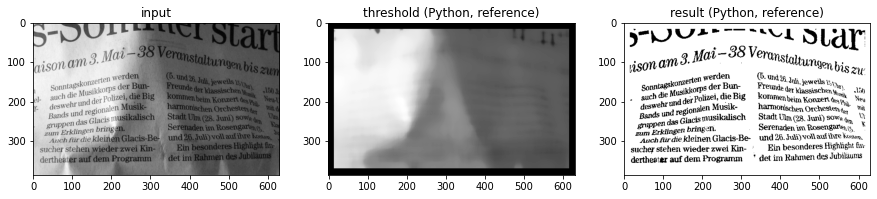

In [27]:
figure(figsize=[15,5])

subplot(1,3,1)
title("input")
imshow(inp.pixel, cm.gray)

subplot(1,3,2)
title("threshold (Python, reference)")
imshow(ref_res.threshold.pixel, cm.gray)

subplot(1,3,3)
title("result (Python, reference)")
imshow(ref_res.result.pixel, cm.gray);

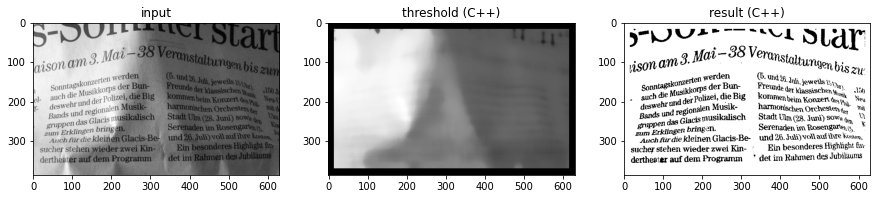

In [28]:
from mdsd.item.io import copy
from my_image_lib_swig import GrayImage as SwigGrayImage
from my_image_lib_swig import BackgroundSubtractionResults as SwigBackgroundSubtractionResults
from my_image_lib_swig import AlgoBackgroundSubtraction as SwigAlgoBackgroundSubtraction
swig_inp = SwigGrayImage()
swig_res = SwigBackgroundSubtractionResults()
res = BackgroundSubtractionResults()
copy(inp, swig_inp)
swig_algo = SwigAlgoBackgroundSubtraction.create()
swig_algo.compute(swig_inp, swig_res)
copy(swig_res, res)

figure(figsize=[15,5])

subplot(1,3,1)
title("input")
imshow(inp.pixel, cm.gray)

subplot(1,3,2)
title("threshold (C++)")
imshow(res.threshold.pixel, cm.gray)

subplot(1,3,3)
title("result (C++)")
imshow(res.result.pixel, cm.gray);

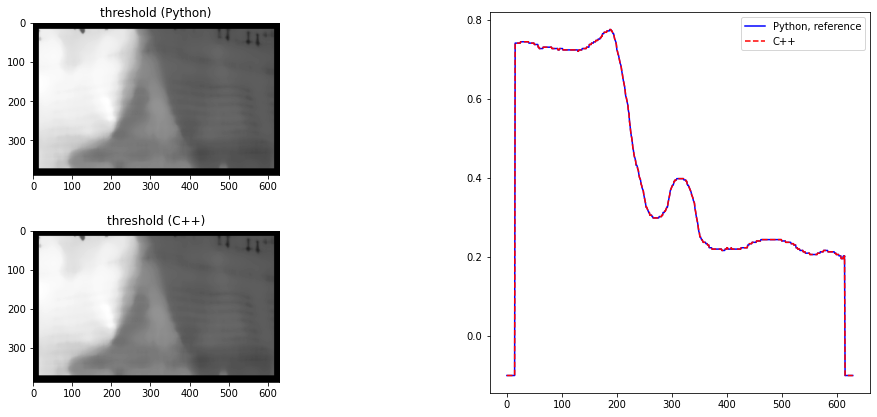

In [29]:
figure(figsize=[15,7])
y = 200

subplot(2,3,1)
title("threshold (Python)")
imshow(ref_res.threshold.pixel, cm.gray)

subplot(2,3,4)
title("threshold (C++)")
imshow(res.threshold.pixel, cm.gray)

subplot(1,2,2)
plot(ref_res.threshold.pixel[y,:], 'b-', label="Python, reference")
plot(res.threshold.pixel[y,:], 'r--', label="C++")
legend()